In [ ]:
import os
import json
from zipfile import ZipFile
from PIL import Image

In [ ]:
kaggle_credentials = json.load(open("kaggle.json"))

In [ ]:
# Setup kaggle api key as enviromnet variable

os.environ['KAGGLE_USERNAME']= kaggle_credentials["username"]

os.environ['KAGGLE_KEY']= kaggle_credentials["key"]

In [ ]:
! kaggle datasets download jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.33G/1.33G [00:14<00:00, 163MB/s]
100% 1.33G/1.33G [00:14<00:00, 95.4MB/s]


In [ ]:
!unzip /content/celeba-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [ ]:
# Imports for usage in training

import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers

# Image/shape is pixel size (64, 64, 3)

In [ ]:
DATA_DIR = "/content/img_align_celeba/img_align_celeba"
IMG_SHAPE = (64, 64, 3)
NUM_IMAGES = 10000
# Setting batch size to 32 per iteration
BATCH_SIZE = 32

In [ ]:
def load_and_preprocess_image(image_path, target_size=(64, 64)):
    """Load and preprocess an image."""
    image = Image.open(image_path).convert('RGB')   # Open the image and convert it to RGB format
    image = image.resize(target_size, Image.LANCZOS) # Resize the image to the target size using Lanczos resampling
    image_array = np.asarray(image, dtype=np.float32) # Convert the image to a numpy array of type float32
    image_array = (image_array - 127.5) / 127.5  # Normalize pixel values to the range [-1, 1] for better

    return image_array # this will return

def load_images(data_dir, num_images, img_shape):
    """Load a specified number of images from the directory."""
    image_files = os.listdir(data_dir)  # List all files in the directory
    np.random.shuffle(image_files)  # Shuffle the list to ensure randomness
    selected_files = image_files[:num_images]  # Select the first `num_images` files from the shuffled list
    images = []  # Initialize an empty list to store the loaded images
    for file_name in selected_files:
        file_path = os.path.join(data_dir, file_name)  # Construct the full file path
        # Check if the item is a file before attempting to open it
        if os.path.isfile(file_path):
            image = load_and_preprocess_image(file_path, img_shape[:2])  # Load and preprocess the image
            images.append(image)  # Append the preprocessed image to the list
    return np.array(images)  # Convert the list of images to a numpy array and return

# Load and preprocess images
images = load_images(DATA_DIR, NUM_IMAGES, IMG_SHAPE)  # Call the function to load and preprocess images
print(f"Loaded {images.shape[0]} images of shape {images.shape[1:]}.")  # Print the number of loaded images and their shape

Loaded 10000 images of shape (64, 64, 3).


In [ ]:
# Define the GAN components
def build_generator():
    model = tf.keras.Sequential()  # Initialize a sequential model
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))  # First dense layer with output size 8*8*256 and input shape 100 (latent dimension)
    model.add(layers.BatchNormalization())  # Batch normalization layer subtracting the mean and dividing by the standard deviation of each mini-batch
    model.add(layers.LeakyReLU())  # LeakyReLU activation layer
    model.add(layers.Reshape((8, 8, 256)))  # Reshape the output to 8x8x256

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))  # First transposed convolution layer with 128 filters, 5x5 kernel, and stride of 2
    model.add(layers.BatchNormalization())  # Batch normalization layer
    model.add(layers.LeakyReLU())  # LeakyReLU activation layer

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))  # Second transposed convolution layer with 64 filters, 5x5 kernel, and stride of 2
    model.add(layers.BatchNormalization())  # Batch normalization layer
    model.add(layers.LeakyReLU())  # LeakyReLU activation layer

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))  # Final transposed convolution layer with 3 filters (output RGB image), 5x5 kernel
    return model

In [ ]:
from IPython.display import Image as Img
from tensorflow.keras.utils import plot_model
from keras.utils import model_to_dot

In [ ]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (Batch  (None, 16384)             65536     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 128)       5

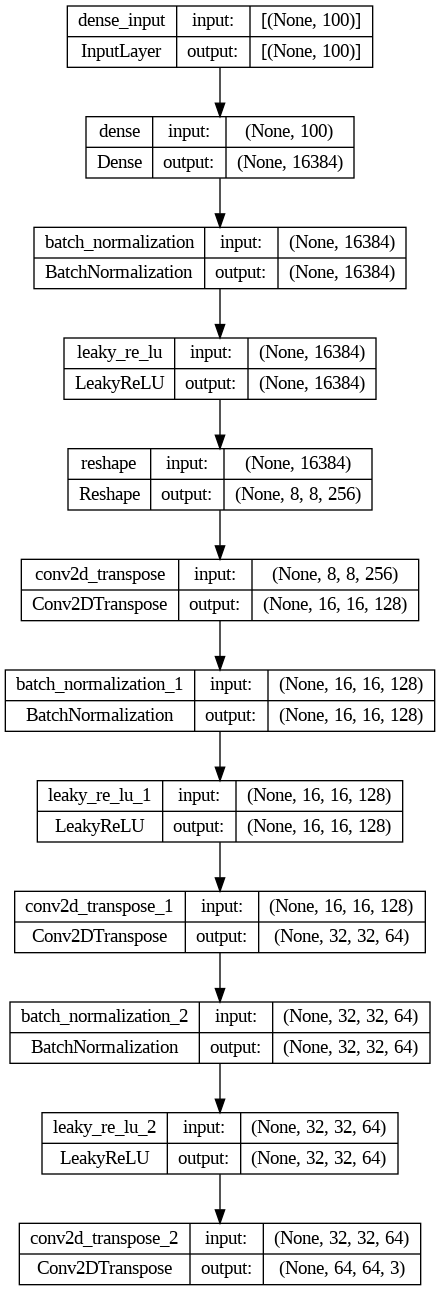

In [ ]:
Img(model_to_dot(generator, show_shapes=True).create_png())

In [ ]:
def build_discriminator():
    """Build the discriminator model."""
    model = tf.keras.Sequential()  # Initialize a sequential model
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=IMG_SHAPE))  # First convolutional layer with 64 filters, 5x5 kernel, stride of 2, and same padding
    model.add(layers.LeakyReLU())  # LeakyReLU activation layer
    model.add(layers.Dropout(0.3))  # Dropout layer with a dropout rate of 0.3

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))  # Second convolutional layer with 128 filters, 5x5 kernel, stride of 2, and same padding
    model.add(layers.LeakyReLU())  # LeakyReLU activation layer
    model.add(layers.Dropout(0.3))  # Dropout layer with a dropout rate of 0.3

    model.add(layers.Flatten())  # Flatten the output to prepare for the dense layer
    model.add(layers.Dense(1, activation='sigmoid'))  # Dense layer with a single output and sigmoid activation (for binary classification)
    return model  # Return the discriminator model

# Instantiate GAN components
generator = build_generator()  # Instantiate the generator model
discriminator = build_discriminator()  # Instantiate the discriminator model

In [ ]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 flatten (Flatten)           (None, 32768)            

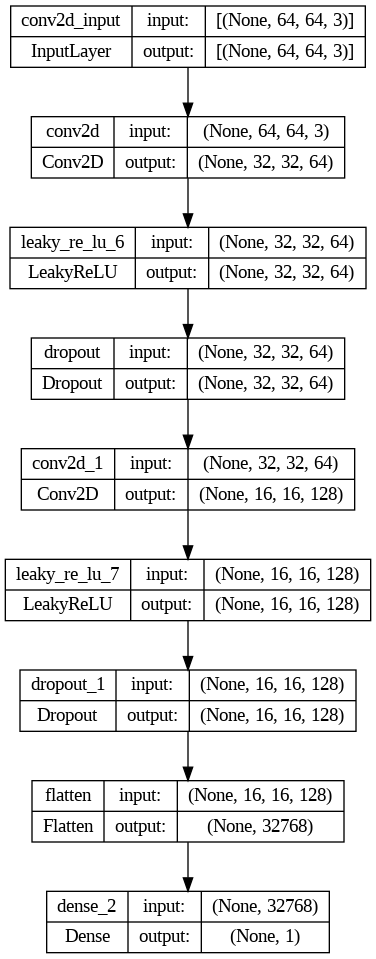

In [ ]:
Img(model_to_dot(discriminator, show_shapes=True).create_png())

In [ ]:
# Define the loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Remember to recopy file path of 'img_align_celeba' within it's own file under content

In [ ]:
import matplotlib.pyplot as plt
import time

# Lists to store generator and discriminator losses
gen_loss = []
disc_loss = []

# Dimensionality of the noise vector (latent space)
noise_dim = 100

# Training step function
@tf.function
def train_step(real_images):
    """Performs a single training step for both the generator and discriminator."""
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  # Generate random noise for the generator
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)  # Generate images from the noise
        real_output = discriminator(real_images, training=True)  # Get discriminator output for real images
        fake_output = discriminator(generated_images, training=True)  # Get discriminator output for fake images

        # Calculate generator loss
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        # Calculate discriminator loss
        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + \
                    cross_entropy(tf.zeros_like(fake_output), fake_output)

    # Compute gradients for the generator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Compute gradients for the discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply the gradients to the generator
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    # Apply the gradients to the discriminator
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss  # Return the generator and discriminator losses

def generate_and_save_images(model, epoch, noise_dim):
    """Generates and saves images from the generator model."""
    noise = tf.random.normal([16, noise_dim])  # Generate random noise
    predictions = model(noise, training=False)  # Generate images from the noise

    fig = plt.figure(figsize=(4, 4))  # Create a figure to display the images

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)  # Add a subplot for each generated image
        plt.imshow((predictions[i] * 127.5 + 127.5).numpy().astype('uint8'))  # Rescale the image values to [0, 255]
        plt.axis('off')  # Turn off the axis

    plt.show()  # Display the images

def train(dataset, epochs):
    """Trains the GAN for a specified number of epochs."""
    for epoch in range(epochs):
        start = time.time()  # Record the start time of the epoch

        for image_batch in dataset:
            gen_loss_value, disc_loss_value = train_step(image_batch)  # Perform a training step
            gen_loss.append(gen_loss_value.numpy())  # Append generator loss to the list
            disc_loss.append(disc_loss_value.numpy())  # Append discriminator loss to the list

        # Print the losses and time taken for the epoch
        print('-' * 50)  # Separator line
        print(f'Epoch {epoch + 1}, Generator Loss: {gen_loss_value}, Discriminator Loss: {disc_loss_value}')
        print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')

        # Generate and save images every 5 epochs
        if (epoch + 1) % 2 == 0:
            generate_and_save_images(generator, epoch + 1, noise_dim)

with tf.device('/gpu:0'):
    # Create a TensorFlow dataset from the images, shuffle, and batch them
    train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(1000).batch(BATCH_SIZE)

    # Train the GAN for a specified number of epochs
    train(train_dataset, epochs=1)

--------------------------------------------------
Epoch 1, Generator Loss: 1.2826348543167114, Discriminator Loss: 1.2066444158554077
Time for epoch 1 is 403.9642548561096 sec


In [ ]:
from tensorflow.keras.models import load_model

# Replace 'your_model_path' with the actual path to your model
model_path = '/content/gan_celebal.h5'  # Path to the saved GAN generator model
generator = load_model(model_path)  # Load the generator model from the specified path

In [ ]:
import os

def save_model_weights(generator, discriminator, save_dir='/content/drive/MyDrive/gan_weights'):
    """Save the weights of the generator and discriminator models."""
    if not os.path.exists(save_dir):  # Check if the save directory exists
        os.makedirs(save_dir)  # Create the save directory if it doesn't exist

    # Save the weights of the generator model
    generator.save_weights(os.path.join(save_dir, 'generator_epoch.h5'))
    # Save the weights of the discriminator model
    discriminator.save_weights(os.path.join(save_dir, 'discriminator_epoch.h5'))

# Save the weights of the generator and discriminator models
save_model_weights(generator, discriminator)

1/1 [==============================] - 0s 266ms/step


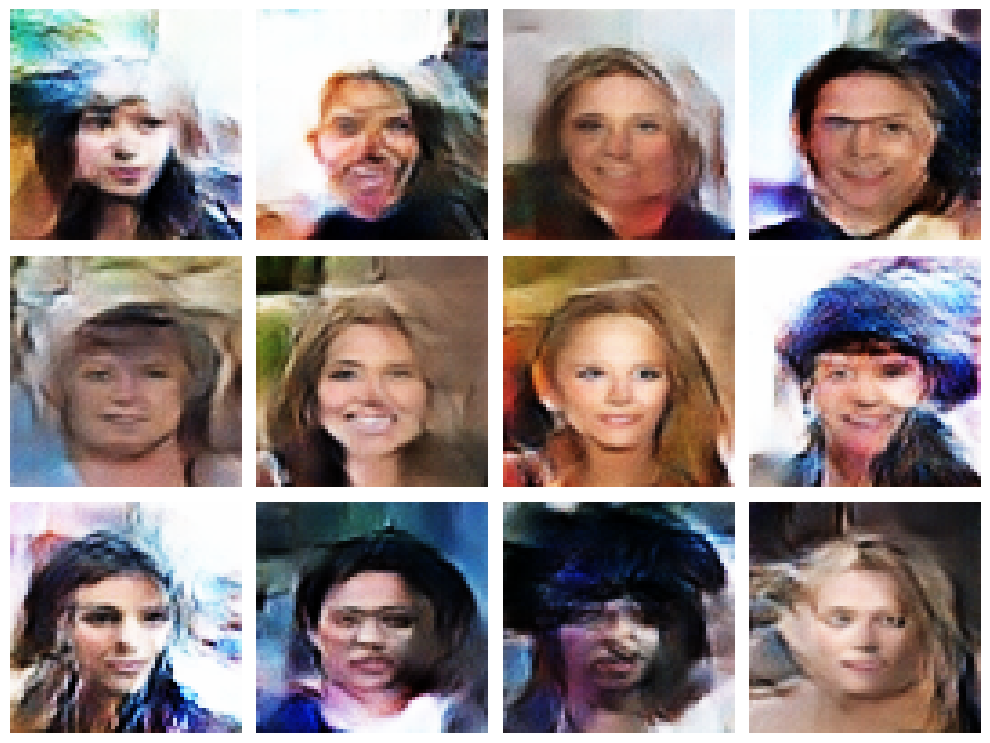

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate and plot fake images
def generate_and_plot_images(generator, noise_dim, num_images=16, figsize=(10, 10)):
    """Generate and plot fake images using the generator model."""
    noise = np.random.normal(0, 1, size=(num_images, noise_dim))  # Generate random noise
    generated_images = generator.predict(noise)  # Generate images from the noise using the generator

    # Rescale images from [-1, 1] to [0, 1]
    generated_images = 0.5 * generated_images + 0.5

    plt.figure(figsize=figsize)  # Create a figure for plotting
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)  # Add a subplot for each generated image
        plt.imshow(generated_images[i])  # Display the image
        plt.axis('off')  # Turn off the axis
    plt.tight_layout()  # Adjust subplots to fit into the figure area
    plt.show()  # Display the plot

# Example usage
noise_dim = 100  # Dimensionality of the input noise vector
num_images_to_generate = 12  # Number of fake images to generate

# Generate and plot fake images
generate_and_plot_images(generator, noise_dim, num_images=num_images_to_generate)

In [ ]:
generator.save('gan_celebal.h5')

# Alternatively, save only the model weights
generator.save_weights('gan_celebal_weights.h5')

In [ ]:
generator.load_weights('/content/gan_celebal.h5')

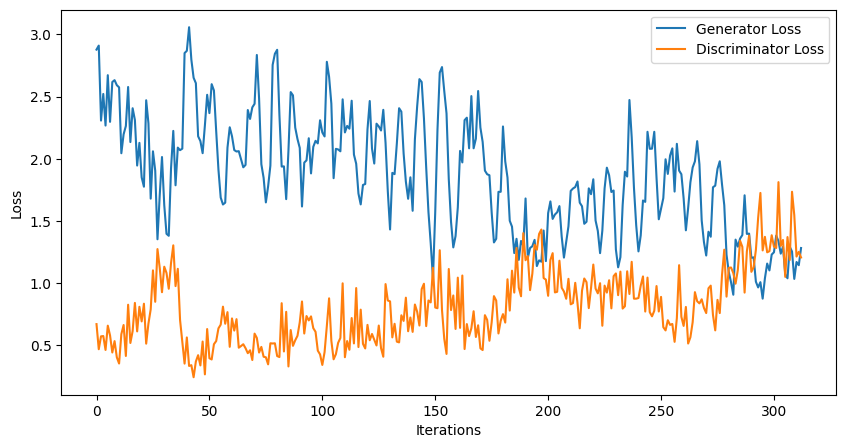

In [ ]:
def plot_losses(gen_loss, disc_loss):
    """Plot the generator and discriminator losses."""
    plt.figure(figsize=(10, 5))
    plt.plot(gen_loss, label='Generator Loss')
    plt.plot(disc_loss, label='Discriminator Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call plot_losses after training
plot_losses(gen_loss, disc_loss)
